In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.aqua.components.optimizers import COBYLA

In [2]:
def even_block():
    #set of 4 initial Rz gates and then a combination of Cz gates (two-qubit gate)
    pass

def odd_block(): 
    
    #set of 4 Rx gates applied to each qubit
    pass
    
def layer_block():
    
    #an even block + odd block -> one layer
    pass

In [3]:
#qiskit even block
def even_block(qc):
    
    for i in range(4):
        qc.rz(np.pi/2,i) #this must be a parametrized circuit 4 four different angles, e.g theta[i]
    
    tuples = [(i,j) for i in range(4) for j in range(4) if i < j]

    for tup in tuples:
        qc.cz(tup[0], tup[1])

In [4]:
#qiskit  odd block
def odd_block(qc):
    
    for i in range(4):
        qc.rx(np.pi/2, i)

In [5]:
def layer(qc):
    
    odd_block(qc)
    even_block(qc)
    qc.barrier()

In [6]:
def built_circuit(number_layers):
    
    qc = QuantumCircuit(4)
    for i in range(number_layers):
        layer(qc)
    return qc

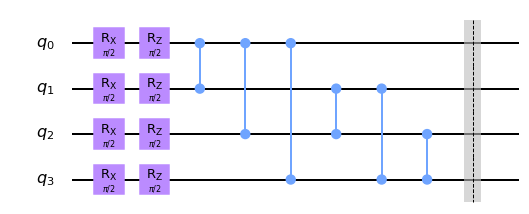

In [7]:
qc = built_circuit(1)

qc.draw(output='mpl')

## Simple example - Optimize the circuit for creating a Bell state

In [8]:
#trivial solution
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)
qc.h(0) # Put qubit a into state |+>
qc.cx(0,1) # CNOT with a as control and b as target
qc.measure(0,0)
qc.measure(1,1)
qc.draw()

┌───┐     ┌─┐   
q0_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q0_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c0: 2/═══════════╩══╩═
                 0  1

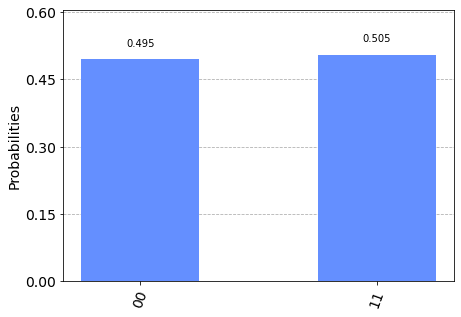

In [9]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

In [10]:
dev = qml.device('default.qubit', wires = 2)
qml.QubitStateVector(np.array([]), wires = 1)

QubitStateVector(tensor([], dtype=float64, requires_grad=True), wires=[1])

In [11]:
@qml.qnode(dev)
def circuit(params):
    A = np.array([[ 0.5, 0.5],
           [ 0.5,  0.5]])
    qml.U3(params[0], params[1], params[2], wires = 0)
    
    return qml.expval(qml.Hermitian(A, wires = 0))

In [12]:
params = [np.pi*0.5, 0, 0.3]
a = circuit(params)
a

0.9999999999999996

In [13]:
def cost(x):
    
    return (1.0 - circuit(x))

In [14]:
init_params = np.array([0.7, 0, 0.3])
cost(init_params)

0.17789115638115482

In [15]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [16]:
for i in range(steps):
    
    params = opt.step(cost, params)
    
print(params)

[1.57079633 0.         0.3       ]


In [17]:
cost(params)

4.440892098500626e-16

In [18]:
Z = np.random.random(2) + np.random.random(2) * 1j

a = np.array([3, 4j])
a.shape

(2,)

## Generating a proper random quantum state and its probability vector

Explain some things here
$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

$|v| = \sqrt{\langle v| v \rangle} = \sqrt{v^{\dagger}v}$

In [19]:
def norm(complex_vector: np.array) -> float:
    """Returns the norm of a complex vector.
    
    Args:
       complex_vector (np.arrray of shape (dim,)):
           complex vector with an arbitrary dimension.
           
       
    Returns:
        norm (float): norm or magnitude of the complex vector.
            
    """
    
    #define the norm of a complex vector here
    norm = np.sqrt(sum([np.square(np.absolute(complex_vector[i])) for i in range(complex_vector.shape[0])]))
    
    return norm

def random_quantum_state(dim: int) -> np.array:
    """Creates a normalized random complex vector of a defined
    dimension.
    
    Args:
        dim (int): integer number specifying the dimension
            of the vector that we want to generate.
            
    Returns:
        (np.array): normalized complex vector of the given
            dimension.
    """
    #generate an unnormalized complex vector of dimension = dim
    Z = np.random.random(dim) + np.random.random(dim)*1j
    
    #normalize the complex vector Z
    Z /= norm(Z)
    
    return Z

def get_probabilities(complex_vector: np.array) -> np.array:
    """Get the probabilities associated to a quantum state.
    This is a vector in which each element is the square of
    the magnitude of respective complex number in that element.
    
    Args:
        complex_vector (np.array):
        
    Retuns:
        (np.array): 
    """
    
    if 1.0 - norm(complex_vector) > 0.001:
        print("Alert! The quantum state apparently is not normalized.")
        
    else:
        return np.square(np.absolute(complex_vector))

In [20]:
#two qubits -> a complex vector of dimension 4
n_qubits = 3
dim = 2**(n_qubits)
psi = random_quantum_state(dim)

In [21]:
get_probabilities(psi)

tensor([0.20827292, 0.36764377, 0.0748437 , 0.0279293 , 0.11163818,
        0.05330202, 0.06641652, 0.08995359], requires_grad=True)

In [23]:
n_qubits = 1
dim = 2**(n_qubits)
psi = random_quantum_state(dim)

In [24]:
target_distr = get_probabilities(psi)
target_distr

tensor([0.62506363, 0.37493637], requires_grad=True)

In [25]:
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

In [26]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    return output_distr

def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    qc = get_var_form(params)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.absolute(output_distr[i] - target_distr[i]) for i in range(2)])
    return cost

In [27]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

Target Distribution: [0.62506363 0.37493637]
Obtained Distribution: [0.622, 0.378]
Output Error (Manhattan Distance): 0.009527251585296603
Parameters Found: [1.31504404 0.48075014 0.78013234]


In [28]:
z = 3-2j
np.absolute(z)

3.605551275463989

In [29]:
np.square(13)

169

## Building the variational quantum circuit

In [ ]:
def built_circuit(number_layers, params):
    #how many parameters will have given the number_layers
    n_parameters = 8*number_layers
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a circuit of {n_parameters} parameters.")
        
    else:
        #create the circuit
        qr = QuantumRegister(4, name="q")
        cr = ClassicalRegister(4, name="c")
        qc = QuantumCircuit(qr, cr)

        #number of parameters per layer
        n_parameters_per_layer = 8
        for i in range(number_layers):
            start = i*n_parameters_per_layer
            end = (i+1)*n_parameters_per_layer 
            layer(qc, params[start:end])
        return qc

In [33]:
n_parameters_per_layer = 8
n_layers = 3
params = np.random.rand(3*8)
print(params)
for i in range(n_layers):
    start = i*n_parameters_per_layer
    end = (i+1)*n_parameters_per_layer 
    vect = params[start:end]
    print(vect.shape)

[0.78114645 0.44011111 0.23426105 0.77285297 0.57948712 0.45249367
 0.39910712 0.15907058 0.50188056 0.47893137 0.80945547 0.87625224
 0.00761428 0.93576667 0.97962914 0.92309129 0.46722613 0.0385172
 0.83624034 0.64222057 0.93201721 0.10718457 0.34088428 0.95465909]
(8,)
(8,)
(8,)
